In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [4]:
data1 = pd.read_csv('../../data/stock_week.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
data1['ds'] = pd.to_datetime(data1['week_start'])

In [7]:
data1.drop(['week_start'],axis=1,inplace=True)

In [8]:
data1.head()

,StockCode,Quantity,Price,holiday,ds
0,20677,96.000000,1.583599,-1.0,2010-05-31
1,20677,10.500000,1.583599,-1.0,2010-06-07
2,20677,32.000000,1.583599,-1.0,2010-06-14
3,20677,30.833333,1.583599,-1.0,2010-06-21
4,20677,123.666667,1.583599,-1.0,2010-06-28


In [9]:
data1['year'] = data1['ds'].dt.year

In [10]:
data1 = data1.loc[data1['year'] > 2009,]

In [11]:
def norm(x):
  y = np.sum(np.square(x))
  y = np.sqrt(y)
  return y

In [12]:
mu = data1.groupby(['StockCode'])['Quantity'].mean().reset_index()
std = data1.groupby(['StockCode'])['Quantity'].std().reset_index()
norm = data1.groupby(['StockCode'])['Quantity'].apply(norm).reset_index()

In [13]:
def range(x):
  xmin = np.min(x)
  xmax = np.max(x)
  rng = xmin-xmin
  return rng

def iqr(x):
  q1, q3 = np.percentile(x,[.25,.75])
  iqr = q3-q1
  return iqr

def median(x):
  med = np.percentile(x,[.5])
  return med[0]


In [14]:
range1 = data1.groupby(['StockCode'])['Quantity'].apply(range).reset_index()
iqr1 = data1.groupby(['StockCode'])['Quantity'].apply(iqr).reset_index()
med = data1.groupby(['StockCode'])['Quantity'].apply(median).reset_index()
skewness = data1.groupby(['StockCode'])['Quantity'].skew().reset_index()

In [15]:
from scipy.stats import kurtosis
def kurt(x):
  y = kurtosis(x)
  return y

In [16]:
kurt = data1.groupby(['StockCode'])['Quantity'].apply(kurt).reset_index()

In [17]:
norm.head()

,StockCode,Quantity
0,20677,523.144097
1,20679,741.564396
2,20681,160.168224
3,20682,281.718416
4,20684,97.577213


In [18]:
mu = mu.rename(columns={'Quantity':'mu'})
std = std.rename(columns={'Quantity':'std'})
norm = norm.rename(columns={'Quantity':'norm'})
range1 = range1.rename(columns={'Quantity':'range'})
iqr1 = iqr1.rename(columns={'Quantity':'iqr'})
med = med.rename(columns={'Quantity':'median'})
skewness = skewness.rename(columns={'Quantity':'skew'})
kurt = kurt.rename(columns={'Quantity':'kurt'})


In [19]:
stock = mu.merge(std,on=['StockCode'],how='left')
stock = stock.merge(norm,on= ['StockCode'],how='left')
stock = stock.merge(range1,on= ['StockCode'],how='left')
stock = stock.merge(iqr1,on= ['StockCode'],how='left')
stock = stock.merge(med,on= ['StockCode'],how='left')
stock = stock.merge(skewness,on= ['StockCode'],how='left')
stock = stock.merge(kurt,on= ['StockCode'],how='left')

In [20]:
stock.head()

,StockCode,mu,std,norm,range,iqr,median,skew,kurt
0,20677,45.452000,40.057125,523.144097,0.0,0.37,0.37,1.581741,2.121358
1,20679,30.785438,69.504593,741.564396,0.0,0.00,1.00,6.912474,50.760939
2,20681,9.778621,13.168624,160.168224,0.0,0.00,0.00,2.644097,9.345227
3,20682,21.461806,19.234506,281.718416,0.0,0.00,0.00,2.273952,6.204668
4,20684,5.049479,8.628946,97.577213,0.0,0.00,0.00,5.606145,40.661814


In [21]:
data1['timeelapsed'] = data1.groupby(['StockCode'])[['ds']].shift(1)
data1['timeelapsed'] = (data1['ds'].sub(data1['timeelapsed'],axis=0).dt.days//7).fillna(1)
data1['cumsum'] = data1.groupby(['StockCode'])['Quantity'].cumsum()
data1['cumdist'] = data1.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1
averagedistance = data1.groupby(['StockCode'])['cumdist'].mean().reset_index().rename(columns={'cumdist':'averagedistance'})
data1 = data1.merge(averagedistance,on=['StockCode'],how='left')

In [22]:
data1.head()

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance
0,20677,96.000000,1.583599,-1.0,2010-05-31,2010,1.0,96.000000,0.0,0.013333
1,20677,10.500000,1.583599,-1.0,2010-06-07,2010,1.0,106.500000,0.0,0.013333
2,20677,32.000000,1.583599,-1.0,2010-06-14,2010,1.0,138.500000,0.0,0.013333
3,20677,30.833333,1.583599,-1.0,2010-06-21,2010,1.0,169.333333,0.0,0.013333
4,20677,123.666667,1.583599,-1.0,2010-06-28,2010,1.0,293.000000,0.0,0.013333


In [23]:
avg_feature = data1.groupby(['StockCode'])[['StockCode','cumdist','averagedistance']].tail(1)

In [24]:
avg_feature = avg_feature.reset_index(drop=True)

In [25]:
avg_feature.head()

,StockCode,cumdist,averagedistance
0,20677,0.0,0.013333
1,20679,0.0,0.000000
2,20681,0.0,1.906250
3,20682,0.0,0.041667
4,20684,0.0,0.864583


In [26]:
stock = stock.merge(avg_feature,on=['StockCode'],how='left')

In [36]:
stock['StockCode'].nunique()

3458

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

In [28]:
sd = StandardScaler()
sd.fit(stock[[x for x in stock.columns if x != 'StockCode']].values)
stock[[x for x in stock.columns if x != 'StockCode']] = sd.transform(stock[[x for x in stock.columns if x != 'StockCode']].values)

In [29]:
stock.head()

,StockCode,mu,std,norm,range,iqr,median,skew,kurt,cumdist,averagedistance
0,20677,0.892511,0.012803,0.113928,0.0,0.374131,0.078737,-1.124451,-0.889648,-0.433799,-0.613550
1,20679,0.404288,0.322967,0.343898,0.0,-0.103819,0.440779,1.309155,1.242103,-0.433799,-0.616606
2,20681,-0.294990,-0.270408,-0.268241,0.0,-0.103819,-0.133891,-0.639460,-0.573044,-0.433799,-0.179702
3,20682,0.093922,-0.206517,-0.140263,0.0,-0.103819,-0.133891,-0.808440,-0.710687,-0.433799,-0.607056
4,20684,-0.452414,-0.318224,-0.334141,0.0,-0.103819,-0.133891,0.712785,0.799483,-0.433799,-0.418447


In [30]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


In [31]:
n_clusters=np.arange(2, 100)

tmp_bic=[]
for n in n_clusters:

  gmm=GMM(n,n_init=2, covariance_type='full').fit(stock[[x for x in stock.columns if x != 'StockCode']].values) 
  tmp_bic.append(gmm.bic(stock[[x for x in stock.columns if x != 'StockCode']].values))
  

In [32]:
np.array(tmp_bic).argmin()

16

In [33]:
gmm=GMM(16, n_init=2,covariance_type='full').fit(stock[[x for x in stock.columns if x != 'StockCode']].values) 

In [34]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


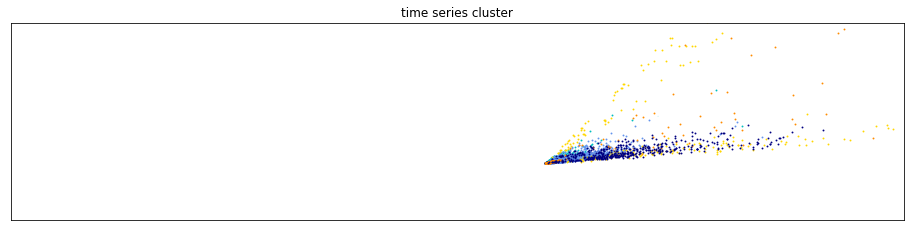

In [35]:
plot_results(stock[[x for x in stock.columns if x != 'StockCode']].values, gmm.predict(stock[[x for x in stock.columns if x != 'StockCode']].values), gmm.means_, gmm.covariances_, 0,
             'time series cluster')

In [37]:
stock['cluster'] = gmm.predict(stock[[x for x in stock.columns if x != 'StockCode']].values)

In [38]:
stock.head()

,StockCode,mu,std,norm,range,iqr,median,skew,kurt,cumdist,averagedistance,cluster
0,20677,0.892511,0.012803,0.113928,0.0,0.374131,0.078737,-1.124451,-0.889648,-0.433799,-0.613550,9
1,20679,0.404288,0.322967,0.343898,0.0,-0.103819,0.440779,1.309155,1.242103,-0.433799,-0.616606,9
2,20681,-0.294990,-0.270408,-0.268241,0.0,-0.103819,-0.133891,-0.639460,-0.573044,-0.433799,-0.179702,12
3,20682,0.093922,-0.206517,-0.140263,0.0,-0.103819,-0.133891,-0.808440,-0.710687,-0.433799,-0.607056,15
4,20684,-0.452414,-0.318224,-0.334141,0.0,-0.103819,-0.133891,0.712785,0.799483,-0.433799,-0.418447,12


In [39]:
data1 = data1.merge(stock[['StockCode','cluster']],on=['StockCode'],how='left')

In [40]:
data1.to_csv('../../data/stock_week_cluster.csv')